# Tarea 3: ¿Qué factor "explica" la muerte por COVID por comuna del Gran Santiago? 
#### Alumno: Carlos Martínez
#### Profesor: Leonardo Ferres
### Fecha: 12-07-2021

Se sabe poco sobre los factores socio-economicos que influyen en el número de muertes por COVID en Chile.

Ahora, su tarea es construir un modelo de regresión en Python para predecir "muertes por covid" teniendo en cuenta el HDI de la comuna, y el número de vacunas administradas. Es decir, su modelo solo tiene que tomar datos desde después del 24 de diciembre de 2020, que es cuando empezamos a administrar vacunas.

Evaluación:

1. Encontrar los datos (10%)
2. Pre-proceso y limpieza de datos (30%)
3. Tratamiento de "muertes por semana" (20%)
4. Gráfico (10%)
5. Explicar el modelo (20%)
6. Subir el notebook a github (10%)

Tienen que mandarme, como resultado, el link al github repo con las tareas. Yo voy a abrir el notebook que se llame: "tarea3.ipynb"

Ps. https://www.statsmodels.org/stable/regression.html

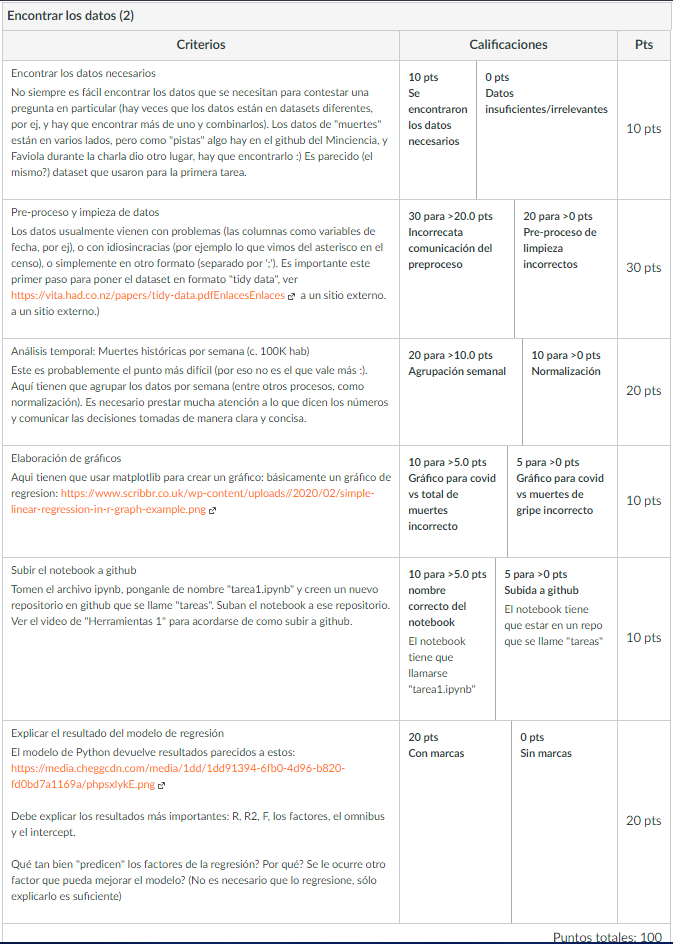

### 1. Encontrar Datos
Se utiliza https://github.com/MinCiencia/Datos-COVID19 para obtener datos relacionados con la situación pandemía, así como https://github.com/leoferres/gitiele356b/tree/main/data para obtener datos del HDI por comuna en la Región Metropolitana. En particular, para este análisis se usará:

* https://github.com/leoferres/gitiele356b/blob/main/data/hdi.csv para obtener el HDI por comuna en el Gran Santiago.
* https://github.com/MinCiencia/Datos-COVID19/blob/master/output/producto38/CasosFallecidosPorComuna.csv para obtener los fallecidos por Comuna en Chile por COVID-19, a partir del 12 de Junio del 2020.
* https://github.com/MinCiencia/Datos-COVID19/blob/master/output/producto80/vacunacion_comuna_UnicaDosis.csv para obtener los vacunados por Comuna, con una única dosis (vacuna Janssen), a partir del 24 de diciembre del 2020.
* https://github.com/MinCiencia/Datos-COVID19/blob/master/output/producto80/vacunacion_comuna_1eraDosis.csv para obtener los vacunados por Comuna, con primera dosis de dos dosis (vacunas Pfizer, Sinovac y AstraZeneca), a partir del 24 de diciembre del 2020.
* https://github.com/MinCiencia/Datos-COVID19/blob/master/output/producto80/vacunacion_comuna_2daDosis.csv para obtener los vacunados por Comuna, con segunda dosis de dos dosis (vacunas Pfizer, Sinovac y AstraZeneca), a partir del 24 de diciembre del 2020.

Se descargan estos archivos en formato csv.

##### Se importan librerías

In [505]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as sm
pd.options.mode.chained_assignment = None  # default='warn'

##### Se leen los archivos csv descargados

In [506]:
raw_HDI = pd.read_csv("hdi.csv")
raw_fallecidos_por_comuna = pd.read_csv("CasosFallecidosPorComuna.csv")
raw_unica_vacuna = pd.read_csv("vacunacion_comuna_UnicaDosis.csv")
raw_1ra_dosis = pd.read_csv("vacunacion_comuna_1eraDosis.csv")
raw_2da_dosis = pd.read_csv("vacunacion_comuna_2daDosis.csv")

El DataFrame `raw_HDI` posee las columnas `['comuna', 'LEI', 'II', 'EI', 'idh', 'HDI']`, de las cuales sólo van a ser importantes `comuna` y `HDI` para este análisis.
A su vez, los DataFrames `raw_fallecidos_por_comuna`, `raw_unica_vacuna`, `raw_1ra_dosis` y `raw_2da_dosis` poseen las columnas `[Region, Codigo region, Comuna, Codigo comuna, Poblacion]`, más una serie de fechas en formato `año-mes-día`. El DataFrame `raw_fallecidos_por_comuna` posee fechas desde el 12 de Junio del 2020 hasta el 9 de Julio del 2021, mientras que los otros DataFrames poseen fechas desde el 24 de Diciembre del 2020 hasta el 11 de Julio del 2021. Cabe destacar que estos datos se van actualizando cada 2 a 3 días.

### 2. Pre-proceso y Limpieza de datos
Se pasa ahora a pre-procesar y limpiar los datos. Para esto, se eliminan los valores nulos de `Codigo comuna` en todos los DataFrames. Luego, usando `raw_HDI`, se limpian del resto de los DataFrames todas las comunas que no están en la Región Metropolitana, y se hace un join entre los DataFrames y `raw_HDI` para añadirles la columna `HDI`.

Luego, las columnas `Region` y `Codigo region` se pueden eliminar.

In [507]:
fallecidos_por_comuna_nonull = raw_fallecidos_por_comuna[raw_fallecidos_por_comuna['Codigo comuna'].isna() == False]

In [508]:
fallecidos_por_comuna_nonull['Codigo comuna'] = fallecidos_por_comuna_nonull['Codigo comuna'].apply(int)
fallecidos_RM = fallecidos_por_comuna_nonull[fallecidos_por_comuna_nonull['Codigo comuna'].apply(lambda x: x in raw_HDI['comuna'].tolist())]
fallecidos_RM = fallecidos_RM[fallecidos_RM.columns[2:]]
fallecidos_RM_HDI = fallecidos_RM.join(raw_HDI[['comuna','HDI']].set_index('comuna'), on='Codigo comuna')
fallecidos_RM_HDI.head()

,Comuna,Codigo comuna,Poblacion,2020-06-12,2020-06-15,2020-06-19,2020-06-23,2020-06-28,2020-07-01,2020-07-05,...,2021-06-11,2021-06-14,2021-06-18,2021-06-21,2021-06-25,2021-06-28,2021-07-02,2021-07-05,2021-07-09,HDI
94,Alhue,13502,7405.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,...,11.0,11.0,11.0,11.0,12.0,12.0,12.0,12.0,13.0,0.742609
95,Buin,13402,109641.0,24.0,26.0,32.0,34.0,46.0,49.0,54.0,...,191.0,194.0,199.0,198.0,202.0,206.0,209.0,215.0,218.0,0.766439
96,Calera de Tango,13403,28525.0,0.0,0.0,1.0,2.0,3.0,3.0,5.0,...,39.0,39.0,40.0,41.0,41.0,43.0,45.0,45.0,45.0,0.715509
97,Cerrillos,13102,88956.0,19.0,24.0,31.0,35.0,42.0,51.0,53.0,...,197.0,198.0,201.0,204.0,206.0,207.0,213.0,220.0,224.0,0.764616
98,Cerro Navia,13103,142465.0,77.0,95.0,108.0,122.0,173.0,183.0,194.0,...,510.0,514.0,524.0,523.0,531.0,543.0,553.0,555.0,563.0,0.718874


In [509]:
unica_vacuna_nonull = raw_unica_vacuna[raw_unica_vacuna['Codigo comuna'].isna() == False]

In [510]:
unica_vacuna_nonull['Codigo comuna'] = unica_vacuna_nonull['Codigo comuna'].apply(int)
unica_vacuna_RM = unica_vacuna_nonull[unica_vacuna_nonull['Codigo comuna'].apply(lambda x: x in raw_HDI['comuna'].tolist())]
unica_vacuna_RM = unica_vacuna_RM[unica_vacuna_RM.columns[2:]]
unica_vacuna_RM_HDI = unica_vacuna_RM.join(raw_HDI[['comuna','HDI']].set_index('comuna'), on='Codigo comuna')
unica_vacuna_RM_HDI.head()

,Comuna,Codigo comuna,Poblacion,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,...,2021-07-03,2021-07-04,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-10,2021-07-11,HDI
88,Alhue,13502,7405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,24.0,14.0,0.0,0.0,0.0,0.0,0.0,0.742609
89,Buin,13402,109641.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.766439
90,Calera de Tango,13403,28525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,42.0,35.0,28.0,25.0,29.0,0.0,0.0,0.715509
91,Cerrillos,13102,88956.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.764616
92,Cerro Navia,13103,142465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.718874


In [511]:
dosis_1_nonull = raw_1ra_dosis[raw_1ra_dosis['Codigo comuna'].isna() == False]

In [512]:
dosis_1_nonull['Codigo comuna'] = dosis_1_nonull['Codigo comuna'].apply(int)
dosis_1_RM = dosis_1_nonull[dosis_1_nonull['Codigo comuna'].apply(lambda x: x in raw_HDI['comuna'].tolist())]
dosis_1_RM = dosis_1_RM[dosis_1_RM.columns[2:]]
dosis_1_RM_HDI = dosis_1_RM.join(raw_HDI[['comuna','HDI']].set_index('comuna'), on='Codigo comuna')
dosis_1_RM_HDI.head()

,Comuna,Codigo comuna,Poblacion,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,...,2021-07-03,2021-07-04,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-10,2021-07-11,HDI
88,Alhue,13502,7405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,10.0,30.0,15.0,20.0,0.0,0.0,0.742609
89,Buin,13402,109641.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,188.0,0.0,301.0,250.0,668.0,436.0,251.0,0.0,0.0,0.766439
90,Calera de Tango,13403,28525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,44.0,26.0,110.0,119.0,91.0,0.0,0.0,0.715509
91,Cerrillos,13102,88956.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,144.0,0.0,240.0,172.0,312.0,191.0,125.0,189.0,0.0,0.764616
92,Cerro Navia,13103,142465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,298.0,44.0,489.0,387.0,378.0,272.0,206.0,476.0,210.0,0.718874


In [513]:
dosis_2_nonull = raw_2da_dosis[raw_2da_dosis['Codigo comuna'].isna() == False]

In [514]:
dosis_2_nonull['Codigo comuna'] = dosis_2_nonull['Codigo comuna'].apply(int)
dosis_2_RM = dosis_2_nonull[dosis_2_nonull['Codigo comuna'].apply(lambda x: x in raw_HDI['comuna'].tolist())]
dosis_2_RM = dosis_2_RM[dosis_2_RM.columns[2:]]
dosis_2_RM_HDI = dosis_2_RM.join(raw_HDI[['comuna','HDI']].set_index('comuna'), on='Codigo comuna')
dosis_2_RM_HDI.head()

,Comuna,Codigo comuna,Poblacion,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,...,2021-07-03,2021-07-04,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-10,2021-07-11,HDI
88,Alhue,13502,7405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,79.0,71.0,66.0,52.0,61.0,0.0,0.0,0.742609
89,Buin,13402,109641.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,143.0,1.0,383.0,460.0,514.0,638.0,433.0,10.0,1.0,0.766439
90,Calera de Tango,13403,28525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2.0,129.0,73.0,112.0,133.0,123.0,9.0,0.0,0.715509
91,Cerrillos,13102,88956.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,117.0,6.0,202.0,242.0,354.0,365.0,190.0,161.0,9.0,0.764616
92,Cerro Navia,13103,142465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,384.0,30.0,441.0,454.0,485.0,505.0,499.0,304.0,132.0,0.718874


##### Cambiar el formato a "tidy data"
Es posible observar que los datos no poseen un formato muy amigable, debido a la forma en que las fechas están mostradas en las columnas. Para solucionar esto, se crearán nuevas tablas con los datos en el formato *tidy data*. Para hacer esto, simplemente se toman todos los DataFrames con fechas, y se les hace un *melt*, dejando todas las columnas que no son fechas, y creando las columnas `Fecha` y `Fallecidos`, `Vacunas Únicas`, `Primeras Dosis` y `Segundas Dosis` para sus tablas respectivas. A las columnas `Fecha`, además, se les cambia el formato de `String` a `Datetime`, y se eliminan los datos de fechas anteriores al 24 de diciembre del 2020.

In [515]:
col = fallecidos_RM_HDI.columns
fallecidos_tidy = pd.melt(fallecidos_RM_HDI, id_vars=['Comuna', 'Codigo comuna', 'Poblacion', 'HDI'], value_vars=col[3:len(col)-1], var_name='Fecha', value_name='Fallecidos')
fallecidos_tidy['Fecha'] = fallecidos_tidy['Fecha'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
fallecidos_tidy = fallecidos_tidy[fallecidos_tidy['Fecha']>=datetime.strptime('2020-12-24', '%Y-%m-%d')]
fallecidos_tidy.head()

,Comuna,Codigo comuna,Poblacion,HDI,Fecha,Fallecidos
2860,Alhue,13502,7405.0,0.742609,2020-12-25,6.0
2861,Buin,13402,109641.0,0.766439,2020-12-25,119.0
2862,Calera de Tango,13403,28525.0,0.715509,2020-12-25,15.0
2863,Cerrillos,13102,88956.0,0.764616,2020-12-25,119.0
2864,Cerro Navia,13103,142465.0,0.718874,2020-12-25,322.0


In [516]:
col = unica_vacuna_RM_HDI.columns
unica_vacuna_tidy = pd.melt(unica_vacuna_RM_HDI, id_vars=['Comuna', 'Codigo comuna', 'Poblacion', 'HDI'], value_vars=col[3:len(col)-1], var_name='Fecha', value_name='Vacunas Únicas')

In [517]:
col = dosis_1_RM_HDI.columns
dosis_1_tidy = pd.melt(dosis_1_RM_HDI, id_vars=['Comuna', 'Codigo comuna', 'Poblacion', 'HDI'], value_vars=col[3:len(col)-1], var_name='Fecha', value_name='Primeras Dosis')

In [518]:
col = dosis_2_RM_HDI.columns
dosis_2_tidy = pd.melt(dosis_2_RM_HDI, id_vars=['Comuna', 'Codigo comuna', 'Poblacion', 'HDI'], value_vars=col[3:len(col)-1], var_name='Fecha', value_name='Segundas Dosis')

A su vez, es posible ver que las tablas creadas `unica_vacuna_tidy`, `dosis_1_tidy` y `dosis_2_tidy` poseen el mismo número de filas, 5 columnas iguales, y los mismos elementos para dichas filas y columnas.

In [519]:
unica_vacuna_tidy[unica_vacuna_tidy.columns[:5]].equals(dosis_1_tidy[dosis_1_tidy.columns[:5]])

True

In [520]:
unica_vacuna_tidy[unica_vacuna_tidy.columns[:5]].equals(dosis_2_tidy[dosis_2_tidy.columns[:5]])

True

 Para trabajar con menor cantidad de tablas, se hace un join entre esos 3 DataFrames.

In [521]:
vacunaciones = unica_vacuna_tidy.merge(dosis_1_tidy, how='outer').merge(dosis_2_tidy, how='outer')
vacunaciones['Fecha'] = vacunaciones['Fecha'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
vacunaciones.head()

,Comuna,Codigo comuna,Poblacion,HDI,Fecha,Vacunas Únicas,Primeras Dosis,Segundas Dosis
0,Alhue,13502,7405.0,0.742609,2020-12-24,0.0,0.0,0.0
1,Buin,13402,109641.0,0.766439,2020-12-24,0.0,0.0,0.0
2,Calera de Tango,13403,28525.0,0.715509,2020-12-24,0.0,0.0,0.0
3,Cerrillos,13102,88956.0,0.764616,2020-12-24,0.0,0.0,0.0
4,Cerro Navia,13103,142465.0,0.718874,2020-12-24,0.0,0.0,0.0


### 3. Tratamiento de "muertes por semana"
Se pasa ahora a separar los datos por semana. Anteriormente se habían transformado los elementos de las columnas `Fechas` a `Datetime`, con esto, es posible ahora obtener la semana y el año al que pertenece cada fecha, y es posible crear la columna `Semana`. Luego, para obtener los datos por semana, es cosa de agrupar los datos por el id de una semana (compuesto por los datos de una comuna y el valor de la semana) y agrupar sumando los valores de `Fallecidos`, `Vacunas Únicas`, `Primeras Dosis` y `Segundas Dosis`.

In [522]:
group_col = ['Comuna', 'Codigo comuna', 'Poblacion', 'HDI', 'Semana']

In [523]:
fallecidos_tidy['Semana'] = fallecidos_tidy['Fecha'].apply(lambda x: x.isocalendar()[0:2])

In [524]:
fallecidos_semanal = fallecidos_tidy.groupby(group_col, as_index=False).sum()
fallecidos_semanal

,Comuna,Codigo comuna,Poblacion,HDI,Semana,Fallecidos
0,Alhue,13502,7405.0,0.742609,"(2020, 52)",6.0
1,Alhue,13502,7405.0,0.742609,"(2020, 53)",12.0
2,Alhue,13502,7405.0,0.742609,"(2021, 1)",12.0
3,Alhue,13502,7405.0,0.742609,"(2021, 2)",12.0
4,Alhue,13502,7405.0,0.742609,"(2021, 3)",12.0
...,...,...,...,...,...,...
1503,Vitacura,13132,96774.0,0.994584,"(2021, 23)",229.0
1504,Vitacura,13132,96774.0,0.994584,"(2021, 24)",235.0
1505,Vitacura,13132,96774.0,0.994584,"(2021, 25)",235.0
1506,Vitacura,13132,96774.0,0.994584,"(2021, 26)",238.0


In [525]:
vacunaciones['Semana'] = vacunaciones['Fecha'].apply(lambda x: x.isocalendar()[0:2])

In [526]:
vacunados_semanal = vacunaciones.groupby(group_col, as_index=False).sum()
vacunados_semanal

,Comuna,Codigo comuna,Poblacion,HDI,Semana,Vacunas Únicas,Primeras Dosis,Segundas Dosis
0,Alhue,13502,7405.0,0.742609,"(2020, 52)",0.0,0.0,0.0
1,Alhue,13502,7405.0,0.742609,"(2020, 53)",0.0,0.0,0.0
2,Alhue,13502,7405.0,0.742609,"(2021, 1)",0.0,0.0,0.0
3,Alhue,13502,7405.0,0.742609,"(2021, 2)",0.0,0.0,0.0
4,Alhue,13502,7405.0,0.742609,"(2021, 3)",0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1503,Vitacura,13132,96774.0,0.994584,"(2021, 23)",266.0,2195.0,4457.0
1504,Vitacura,13132,96774.0,0.994584,"(2021, 24)",0.0,2142.0,3716.0
1505,Vitacura,13132,96774.0,0.994584,"(2021, 25)",665.0,1275.0,4116.0
1506,Vitacura,13132,96774.0,0.994584,"(2021, 26)",319.0,870.0,3010.0


Como ahora todas las tablas poseen el mismo número de filas, y los mismos elementos en `Semana`, es posible también unirlas de la misma forma como se hizo anteriormente.

In [527]:
resumenes_semanales = vacunados_semanal.merge(fallecidos_semanal, how='outer')
resumenes_semanales

,Comuna,Codigo comuna,Poblacion,HDI,Semana,Vacunas Únicas,Primeras Dosis,Segundas Dosis,Fallecidos
0,Alhue,13502,7405.0,0.742609,"(2020, 52)",0.0,0.0,0.0,6.0
1,Alhue,13502,7405.0,0.742609,"(2020, 53)",0.0,0.0,0.0,12.0
2,Alhue,13502,7405.0,0.742609,"(2021, 1)",0.0,0.0,0.0,12.0
3,Alhue,13502,7405.0,0.742609,"(2021, 2)",0.0,0.0,0.0,12.0
4,Alhue,13502,7405.0,0.742609,"(2021, 3)",0.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...
1503,Vitacura,13132,96774.0,0.994584,"(2021, 23)",266.0,2195.0,4457.0,229.0
1504,Vitacura,13132,96774.0,0.994584,"(2021, 24)",0.0,2142.0,3716.0,235.0
1505,Vitacura,13132,96774.0,0.994584,"(2021, 25)",665.0,1275.0,4116.0,235.0
1506,Vitacura,13132,96774.0,0.994584,"(2021, 26)",319.0,870.0,3010.0,238.0


### 4. Graficar
#### Crear gráficos
Ahora, para hacer los gráficos y buscar una correlación entre el HDI de una comuna y su número de vacunas o de fallecidos, se juntan los totales obtenidos de todas las semanas. Esto se hace también agrupando y sumando. A continuación, para corregir los resultados por la población existente en las comunas, se dividen las columnas de Fallecidos y Vacunados por Poblacion, obteniéndose el porcentaje de Población total que ha Fallecido o se ha Vacunado (es necesario recalcar que los datos de Fallecidos y Vacunados son bastante recientes, mientras que los datos de la Población por comuna provienen del Censo 2017, por ende es probable que se presenten ciertas inconsistencias).

Para hacer los gráficos, se hace un scatterplot y se calcula una regresión lineal entre el HDI y los fallecidos/vacunados. A su vez, se calcula el Coeficiente de Correlación de Pearson entre ambas variables, y su valor P.

In [528]:
resumenes_totales_0 = resumenes_semanales.groupby(['Comuna', 'Codigo comuna', 'Poblacion', 'HDI'], as_index=False).sum()
resumenes_totales_0.head()

,Comuna,Codigo comuna,Poblacion,HDI,Vacunas Únicas,Primeras Dosis,Segundas Dosis,Fallecidos
0,Alhue,13502,7405.0,0.742609,293.0,6232.0,5460.0,443.0
1,Buin,13402,109641.0,0.766439,2579.0,74943.0,61052.0,8959.0
2,Calera de Tango,13403,28525.0,0.715509,1026.0,21869.0,18854.0,1441.0
3,Cerrillos,13102,88956.0,0.764616,1993.0,50012.0,42736.0,9105.0
4,Cerro Navia,13103,142465.0,0.718874,2045.0,74917.0,60166.0,23421.0


In [529]:
resumenes_totales = resumenes_totales_0.copy()
columnas_normalizar = ['Vacunas Únicas','Primeras Dosis','Segundas Dosis','Fallecidos']
for col in columnas_normalizar:
    resumenes_totales[col] = resumenes_totales[col]/resumenes_totales['Poblacion']

In [530]:
resumenes_totales

,Comuna,Codigo comuna,Poblacion,HDI,Vacunas Únicas,Primeras Dosis,Segundas Dosis,Fallecidos
0,Alhue,13502,7405.0,0.742609,0.039568,0.841594,0.737340,0.059824
1,Buin,13402,109641.0,0.766439,0.023522,0.683531,0.556835,0.081712
2,Calera de Tango,13403,28525.0,0.715509,0.035968,0.766661,0.660964,0.050517
3,Cerrillos,13102,88956.0,0.764616,0.022404,0.562211,0.480417,0.102354
4,Cerro Navia,13103,142465.0,0.718874,0.014354,0.525862,0.422321,0.164398
5,Colina,13301,180353.0,0.690036,0.025932,0.523773,0.433877,0.061895
6,Conchali,13104,139195.0,0.749584,0.022178,0.712403,0.565207,0.165444
7,Curacavi,13503,36430.0,0.738340,0.041065,0.660966,0.578177,0.060253
8,El Bosque,13105,172000.0,0.742015,0.025890,0.588930,0.471029,0.129145
9,El Monte,13602,40014.0,0.728127,0.034613,0.576998,0.491353,0.100890


##### Fallecidos vs HDI

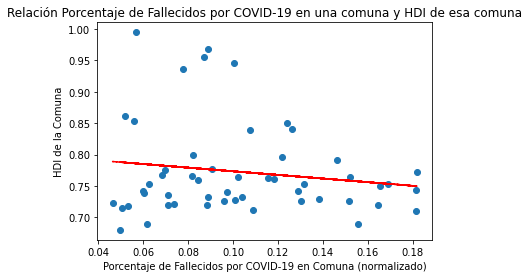

[[ 1.         -0.15290576]
 [-0.15290576  1.        ]]


In [531]:
x = resumenes_totales['Fallecidos']
y = resumenes_totales['HDI']
plt.scatter(x, y, marker = 'o')
p = np.polyfit(x, y, 1)
p1d = np.poly1d(p)
plt.plot(x, p1d(x), 'r--')
plt.title('Relación Porcentaje de Fallecidos por COVID-19 en una comuna y HDI de esa comuna')
plt.xlabel('Porcentaje de Fallecidos por COVID-19 en Comuna (normalizado)')
plt.ylabel('HDI de la Comuna')
plt.show()
print(np.corrcoef(x, y))

In [532]:
corr = pearsonr(x = resumenes_totales['Fallecidos'], y = resumenes_totales['HDI'])
print("- coeficiente de Correlación de Pearson es: " + str(corr[0]))
print("- su valor P es: " + str(corr[1]))

- coeficiente de Correlación de Pearson es: -0.152905757144951
- su valor P es: 0.27916604072980383


##### Vacunas Únicas vs HDI

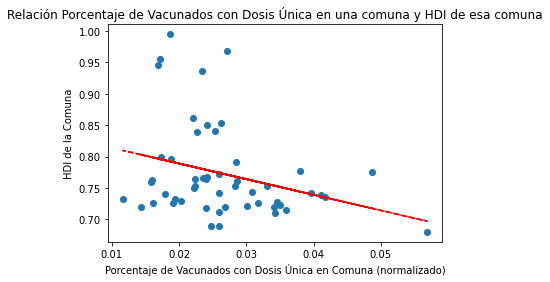

[[ 1.         -0.29941773]
 [-0.29941773  1.        ]]


In [533]:
x = resumenes_totales['Vacunas Únicas']
y = resumenes_totales['HDI']
plt.scatter(x, y, marker = 'o')
p = np.polyfit(x, y, 1)
p1d = np.poly1d(p)
plt.plot(x, p1d(x), 'r--')
plt.title('Relación Porcentaje de Vacunados con Dosis Única en una comuna y HDI de esa comuna')
plt.xlabel('Porcentaje de Vacunados con Dosis Única en Comuna (normalizado)')
plt.ylabel('HDI de la Comuna')
plt.show()
print(np.corrcoef(x, y))

In [534]:
corr = pearsonr(x = resumenes_totales['Vacunas Únicas'], y = resumenes_totales['HDI'])
print("- coeficiente de Correlación de Pearson es: " + str(corr[0]))
print("- su valor P es: " + str(corr[1]))

- coeficiente de Correlación de Pearson es: -0.2994177263537419
- su valor P es: 0.031053521423962827


##### Primeras Dosis vs HDI

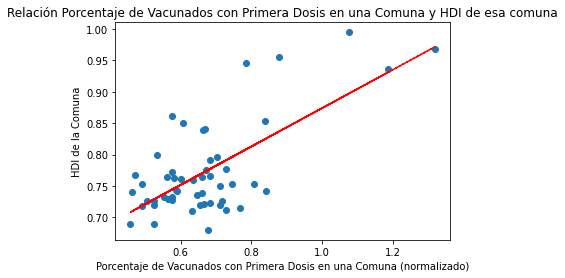

[[1.         0.68713592]
 [0.68713592 1.        ]]


In [535]:
x = resumenes_totales['Primeras Dosis']
y = resumenes_totales['HDI']
plt.scatter(x, y, marker = 'o')
p = np.polyfit(x, y, 1)
p1d = np.poly1d(p)
plt.plot(x, p1d(x), 'r--')
plt.title('Relación Porcentaje de Vacunados con Primera Dosis en una Comuna y HDI de esa comuna')
plt.xlabel('Porcentaje de Vacunados con Primera Dosis en una Comuna (normalizado)')
plt.ylabel('HDI de la Comuna')
plt.show()
print(np.corrcoef(x, y))

In [536]:
corr = pearsonr(x = resumenes_totales['Primeras Dosis'], y = resumenes_totales['HDI'])
print("- coeficiente de Correlación de Pearson es: " + str(corr[0]))
print("- su valor P es: " + str(corr[1]))

- coeficiente de Correlación de Pearson es: 0.6871359173411047
- su valor P es: 1.8492127174116035e-08


##### Segundas Dosis vs HDI

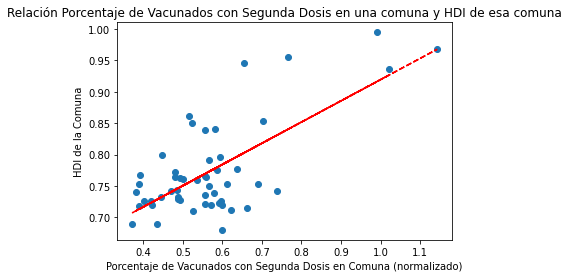

[[1.         0.69755743]
 [0.69755743 1.        ]]


In [537]:
x = resumenes_totales['Segundas Dosis']
y = resumenes_totales['HDI']
plt.scatter(x, y, marker = 'o')
p = np.polyfit(x, y, 1)
p1d = np.poly1d(p)
plt.plot(x, p1d(x), 'r--')
plt.title('Relación Porcentaje de Vacunados con Segunda Dosis en una comuna y HDI de esa comuna')
plt.xlabel('Porcentaje de Vacunados con Segunda Dosis en Comuna (normalizado)')
plt.ylabel('HDI de la Comuna')
plt.show()
print(np.corrcoef(x, y))

In [538]:
corr = pearsonr(x = resumenes_totales['Segundas Dosis'], y = resumenes_totales['HDI'])
print("- Coeficiente de Correlación de Pearson es: " + str(corr[0]))
print("- su valor P es: " + str(corr[1]))

- Coeficiente de Correlación de Pearson es: 0.6975574258853154
- su valor P es: 9.119450300816581e-09


### 5. Aplicar Modelo de Regresión Lineal

#### Regresión Lineal OLS

In [539]:
model = sm.ols(formula = 'Fallecidos ~ HDI + Vacunas_Únicas + Primeras_Dosis + Segundas_Dosis', data = resumenes_totales.rename(columns=lambda x: x.replace(' ','_'))).fit()
print(model.params)

Intercept         0.132276
HDI              -0.042935
Vacunas_Únicas   -0.618544
Primeras_Dosis    0.694500
Segundas_Dosis   -0.785871
dtype: float64


A partir del modelo observado, se puede apreciar que el intercepto ocurre cerca del 13,2% de la población fallecida.

A su vez, se puede apreciar que las pendientes de Vacunas Únicas y de Segundas Dosis son bastante negativas, implicando que existe una disminución de la población fallecida con un aumento en una de estas variables. No así con la pendiente de la Primera Dosis, que es positiva.

Se puede observar también que la pendiente de HDI es negativa, implicando una pequeña disminución en los fallecidos a medida que aumenta el HDI.

In [540]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Fallecidos   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2.707
Date:                Mon, 12 Jul 2021   Prob (F-statistic):             0.0414
Time:                        23:02:05   Log-Likelihood:                 100.46
No. Observations:                  52   AIC:                            -190.9
Df Residuals:                      47   BIC:                            -181.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1323      0.093      1.

Por lo que se puede observar del Summary, se pueden conluir varios puntos:
- El valor P es menor que 0.05 para Primeras Dosis y Segundas Dosis, por ende es una relación significativa para estas.
- El valor R2 es 0.18, por lo que se puede decir que este modelo puede explicar un 18.7% de la variación de la data.
- El valor R2 Ajustado debe ser menor que R2, pues explica el porcentaje de la variación que sólo puede provenir de las variables independientes. En este caso, R2 Ajustado = 11.8% < 18.7% = R2.
- No es posible decir que se predice el correctamente el intercepto, el HDI o Vacunas Únicas, pero sí Primeras Dosis y Segundas Dosis.
- En este caso el F-statistic no es tan bajo, al rededor de 0.0414, por ende no se puede decir que la variable Fallecidos depende de las variables independientes.
- La condición de número no es tan grande, por ende, existe una baja colinealidad de acuerdo a los cambios de los datos.

Una inferencia importante que puede obtenerse de este análisis es que de las variables analizadas, sólo dos de estas tienen posibilidad de predecir correctamente el número de fallecidos por comuna.

### 6. Conclusiones
Gracias a la recolección, limpieza y análisis de los datos anteriores, es posible inferir cuales variables afectan, y cuales variables no afectan precisamente los resultados obtenidos por Comuna. Luego, un análisis más profundo, utilizando otro tipo de métodos y métricas, sería necesario para sacar conclusiones más profundas acerca de los datos.